In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Data

In [2]:
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=10, shuffle=True, drop_last=True)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=10, shuffle=False)

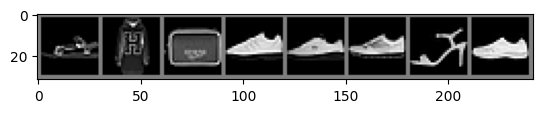

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

#### Model

In [6]:
import torch
import torch.nn as nn
from torchsummary import summary

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=7)
        self.conv4 = nn.Conv2d(128, 10, kernel_size=1)
        
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max pooling
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.relu(x)

        x = self.conv4(x)        
        x = self.flatten(x)
        
        return x

model = CustomModel()
model = model.to(device)

# Print model
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 1, 1]         401,536
              ReLU-8            [-1, 128, 1, 1]               0
            Conv2d-9             [-1, 10, 1, 1]           1,290
          Flatten-10                   [-1, 10]               0
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.61
Estimated T

#### Loss, Optimizer, and Evaluation Function

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

#### Train

In [9]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 100

In [10]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()        

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/100], Loss: 1.7737, Accuracy: 54.71%, Test Loss: 1.1094, Test Accuracy: 69.39%
Epoch [2/100], Loss: 0.8276, Accuracy: 73.79%, Test Loss: 0.6875, Test Accuracy: 75.80%
Epoch [3/100], Loss: 0.6216, Accuracy: 78.27%, Test Loss: 0.5906, Test Accuracy: 78.78%
Epoch [4/100], Loss: 0.5514, Accuracy: 80.43%, Test Loss: 0.5428, Test Accuracy: 80.18%
Epoch [5/100], Loss: 0.5106, Accuracy: 81.84%, Test Loss: 0.5116, Test Accuracy: 81.43%
Epoch [6/100], Loss: 0.4821, Accuracy: 82.88%, Test Loss: 0.4846, Test Accuracy: 82.70%
Epoch [7/100], Loss: 0.4614, Accuracy: 83.68%, Test Loss: 0.4663, Test Accuracy: 83.46%
Epoch [8/100], Loss: 0.4425, Accuracy: 84.41%, Test Loss: 0.4545, Test Accuracy: 83.76%
Epoch [9/100], Loss: 0.4271, Accuracy: 84.99%, Test Loss: 0.4360, Test Accuracy: 84.57%
Epoch [10/100], Loss: 0.4171, Accuracy: 85.33%, Test Loss: 0.4254, Test Accuracy: 84.85%
Epoch [11/100], Loss: 0.4031, Accuracy: 85.79%, Test Loss: 0.4177, Test Accuracy: 85.10%
Epoch [12/100], Loss: 0.3955, 

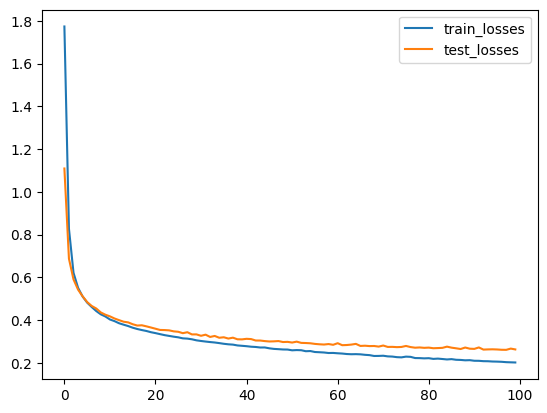

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

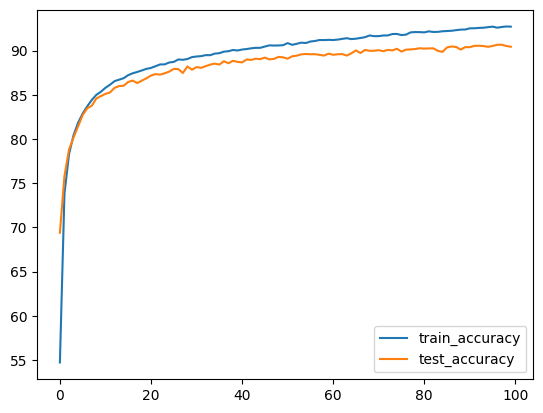

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [13]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

In [14]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()